In [1]:
import torch
import evaluate
import pandas as pd
import numpy as np
from transformers import(
    AutoTokenizer,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset

In [2]:
pd.options.display.max_rows = 100

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} as device.")

Using cuda as device.


In [4]:
model_ckpt = "distilbert-base-cased"

In [6]:
wnut = load_dataset("wnut_17", trust_remote_code=True)

In [7]:
wnut

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3394
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1287
    })
})

Look at the first training example, we see that the text is split into tokens, where each token has an associated label. **We will still have to pass the text through the huggingface tokenizer to create subword tokens that the model expects**.

In [8]:
wnut["train"][0]

{'id': '0',
 'tokens': ['@paulwalk',
  'It',
  "'s",
  'the',
  'view',
  'from',
  'where',
  'I',
  "'m",
  'living',
  'for',
  'two',
  'weeks',
  '.',
  'Empire',
  'State',
  'Building',
  '=',
  'ESB',
  '.',
  'Pretty',
  'bad',
  'storm',
  'here',
  'last',
  'evening',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  8,
  8,
  0,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

We can also see that the `ner_tags` column is a `Sequence` object that's specific to Huggingface. We can use the attributes of this class to extract the label names.

In [9]:
wnut["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-corporation', 'I-corporation', 'B-creative-work', 'I-creative-work', 'B-group', 'I-group', 'B-location', 'I-location', 'B-person', 'I-person', 'B-product', 'I-product'], id=None), length=-1, id=None)}

In [10]:
# navigating the data structure above to get features
label_names = wnut["train"].features["ner_tags"].feature.names
label_names

['O',
 'B-corporation',
 'I-corporation',
 'B-creative-work',
 'I-creative-work',
 'B-group',
 'I-group',
 'B-location',
 'I-location',
 'B-person',
 'I-person',
 'B-product',
 'I-product']

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/root/micromamba/envs/adsp-nlp/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Because the text is already split into words, we use a special keyword argument, `is_split_into_words`, when calling the tokenizer. Remember that tokenization can lead to words being split into sub-words (this is especially true for BERT tokenizers). This is why we still need to pass the tokens through a tokenizer.

In [12]:
sample_text = wnut["train"][0]

tokenized_sample_text = tokenizer(sample_text["tokens"], is_split_into_words=True)
tokenized_sample_text

{'input_ids': [101, 137, 185, 18318, 13868, 1135, 112, 188, 1103, 2458, 1121, 1187, 146, 112, 182, 1690, 1111, 1160, 2277, 119, 2813, 1426, 4334, 134, 142, 19117, 119, 12004, 2213, 4162, 1303, 1314, 3440, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
# printing original tokens as they exist in the data
print(f"Raw tokens: {sample_text['tokens']}")
print(f"Count: {len(sample_text['tokens'])}")
print()

# printing tokens after they have been passed through tokenizer
subword_tokens = tokenizer.convert_ids_to_tokens(tokenized_sample_text['input_ids'])
print(f"Tokenized tokens: {subword_tokens}")
print(f"Count: {len(subword_tokens)}")

Raw tokens: ['@paulwalk', 'It', "'s", 'the', 'view', 'from', 'where', 'I', "'m", 'living', 'for', 'two', 'weeks', '.', 'Empire', 'State', 'Building', '=', 'ESB', '.', 'Pretty', 'bad', 'storm', 'here', 'last', 'evening', '.']
Count: 27

Tokenized tokens: ['[CLS]', '@', 'p', '##aul', '##walk', 'It', "'", 's', 'the', 'view', 'from', 'where', 'I', "'", 'm', 'living', 'for', 'two', 'weeks', '.', 'Empire', 'State', 'Building', '=', 'E', '##SB', '.', 'Pretty', 'bad', 'storm', 'here', 'last', 'evening', '.', '[SEP]']
Count: 35


After tokenization, we can see that the word tokens have been split into subword tokens. Note the difference in length before and after tokenization. **This implies that our original labels aren't aligned anymore (which is why the tokenizer does not return the labels either in its output)**. We will re-align the labels by:
1. Map subword tokens to their origin word token
2. Assign the label to first subword token of a word, setting the rest to -100 (which PyTorch will ignore)
3. Ignore the `[CLS]` and `[SEP]` tokens

Documentation for PyTorch ignoring tokens labeled with -100: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Point (2) is done because above is a design decision. We could choose to assign the word label to each sub-word token. Assigning only to the first subtoken is a common strategy, so we use it here.

Huggingface tokenizers keep track of which word a subtoken belongs to via the `word_ids()` method.

In [14]:
type(tokenized_sample_text)

transformers.tokenization_utils_base.BatchEncoding

In [15]:
tokenized_sample_text.word_ids()

[None,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 None]

Below, we create a dataframe to demonstrate how we can map tokenized text to word id to original word.

In [16]:
# displaying alignment between tokenized words, word ids and the original word
pd.DataFrame(
    data=zip(subword_tokens, tokenized_sample_text.word_ids()),
    columns=["subword_token", "word_id"]
).assign(
    word=[None if word_id is None else sample_text['tokens'][word_id] for word_id in tokenized_sample_text.word_ids()]
)

,subword_token,word_id,word
0,[CLS],NaN,None
1,@,0.0,@paulwalk
2,p,0.0,@paulwalk
3,##aul,0.0,@paulwalk
4,##walk,0.0,@paulwalk
5,It,1.0,It
6,',2.0,'s
7,s,2.0,'s
8,the,3.0,the
9,view,4.0,view


In [17]:
def tokenize_and_align_labels(batch):
    
    # tokenizing the input tokens and truncating the examples that are too long
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)
    
    # container to store the re-aligned labels
    labels = []
    
    for example_idx, example_labels in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=example_idx) # want to specify which example in the batch we are getting ids for
        previous_word_id = None
        label_ids = []
        
        for word_id in word_ids:
            
            # special tokens set to -100
            if word_id is None:
                label_ids.append(-100)
                
            # when current word id is different than previous word id, we are at the beginning of a new word and we store the label 
            elif word_id != previous_word_id:
                label_ids.append(example_labels[word_id])
                
            # subsequent subword tokens get ignored
            else:
                label_ids.append(-100)
                
            previous_word_id = word_id
            
        labels.append(label_ids)
    
    # adding the labels as a column to the tokenized inputs
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

In [18]:
wnut_tokenized = wnut.map(tokenize_and_align_labels, batched=True, remove_columns=["id", "tokens", "ner_tags"])

Map:   0%|          | 0/3394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

In [19]:
wnut_tokenized["train"][0]

{'input_ids': [101,
  137,
  185,
  18318,
  13868,
  1135,
  112,
  188,
  1103,
  2458,
  1121,
  1187,
  146,
  112,
  182,
  1690,
  1111,
  1160,
  2277,
  119,
  2813,
  1426,
  4334,
  134,
  142,
  19117,
  119,
  12004,
  2213,
  4162,
  1303,
  1314,
  3440,
  119,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [-100,
  0,
  -100,
  -100,
  -100,
  0,
  0,
  -100,
  0,
  0,
  0,
  0,
  0,
  0,
  -100,
  0,
  0,
  0,
  0,
  0,
  7,
  8,
  8,
  0,
  7,
  -100,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -100]}

In [20]:
wnut_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3394
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1287
    })
})

Below, we can see that we are using -100 as a way to ignore tokens for two reasons:

1. They are special tokens: `[CLS]` and `[SEP]`
2. For every subtoken that's not the first subtoken for a given word

In [21]:
sample = (
    pd.DataFrame(
        data=zip(
            subword_tokens,
            wnut_tokenized["train"]["labels"][0],
            tokenized_sample_text.word_ids(),
        ),
        columns=["subword_tokens", "labels", "word_ids"]
    )
)

sample["label_name"] = [-100 if val == -100 else label_names[val] for val in sample["labels"]]
sample

,subword_tokens,labels,word_ids,label_name
0,[CLS],-100,NaN,-100
1,@,0,0.0,O
2,p,-100,0.0,-100
3,##aul,-100,0.0,-100
4,##walk,-100,0.0,-100
5,It,0,1.0,O
6,',0,2.0,O
7,s,-100,2.0,-100
8,the,0,3.0,O
9,view,0,4.0,O


Now that our data has been tokenized, we want to create a collator to dynamically pad our data. We use the `DataCollatorForTokenClassification` to do this. Since each token has its own label in token classification tasks, this particular collator ensures that the labels are aligned with the padded tokens, using -100 by default (which is ignore in loss computation in PyTorch)

In [22]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

We now load the evaluation metrics and create a function that will be used by the Transformer `Trainer` object during training to evaluate the model performance. Per the documentation, https://huggingface.co/docs/transformers/en/main_classes/trainer, the function must take an `EvalPrediction` object, which is a tuple of logits and labels.

In [23]:
seqeval = evaluate.load("seqeval")

In [24]:
def compute_metrics(eval_preds):
    
    # unpacking the EvalPrediction output
    logits, labels = eval_preds
    
    # the largest logit is the prediction
    # note the dimensions with which we are taking the max
    # the output dimensions will be (batch_size, sequence_length, num_labels)
    # -1 means we want to find the arg max of the of the dimesnion that contains the labels
    predictions = np.argmax(logits, axis=-1)
    # print(logits.shape, predictions.shape, labels.shape)

    # process predictions to filter out ignored labels (-100)
    preds = []
    for prediction, label in zip(predictions, labels):
        filtered_preds = [label_names[p] for p, l in zip(prediction, label) if l != -100]
        preds.append(filtered_preds)
        
    # process reference labels to filter out ignored labels (-100)
    refs = []
    for label in labels:
        filtered_refs = [label_names[l] for l in label if l != -100]
        refs.append(filtered_refs)

    results = seqeval.compute(predictions=preds, references=refs)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [25]:
idx2label = dict(enumerate(label_names))
label2idx = {v: k for k, v in idx2label.items()}

In [26]:
idx2label

{0: 'O',
 1: 'B-corporation',
 2: 'I-corporation',
 3: 'B-creative-work',
 4: 'I-creative-work',
 5: 'B-group',
 6: 'I-group',
 7: 'B-location',
 8: 'I-location',
 9: 'B-person',
 10: 'I-person',
 11: 'B-product',
 12: 'I-product'}

In [27]:
label2idx

{'O': 0,
 'B-corporation': 1,
 'I-corporation': 2,
 'B-creative-work': 3,
 'I-creative-work': 4,
 'B-group': 5,
 'I-group': 6,
 'B-location': 7,
 'I-location': 8,
 'B-person': 9,
 'I-person': 10,
 'B-product': 11,
 'I-product': 12}

The `AutoModelForTokenClassification` task adds a task specific head to the underlying transformer model. In this case, that task is token classification.

In [28]:
model = AutoModelForTokenClassification.from_pretrained(model_ckpt, num_labels=len(idx2label), id2label=idx2label, label2id=label2idx)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
training_args = TrainingArguments(
    output_dir=f"{model_ckpt}-finetuned-ner-1",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    push_to_hub=False,
)

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=wnut_tokenized["train"],
    eval_dataset=wnut_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.259533,0.612245,0.322967,0.422866,0.939808
2,No log,0.241782,0.624490,0.366029,0.461538,0.943113


/root/micromamba/envs/adsp-nlp/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=426, training_loss=0.20347989221134097, metrics={'train_runtime': 52.6571, 'train_samples_per_second': 128.909, 'train_steps_per_second': 8.09, 'total_flos': 105885281822220.0, 'train_loss': 0.20347989221134097, 'epoch': 2.0})

Next, we can try inferencing using some text for Wikipedia. We will also compare the output of the trained model to the output of a randomly initiatialized model.

In [33]:
sample_text = "The Great Gatsby is a 1925 novel by American writer F. Scott Fitzgerald. Set in the Jazz Age on Long Island, near New York City, the novel depicts first-person narrator Nick Carraway's interactions with mysterious millionaire Jay Gatsby and Gatsby's obsession to reunite with his former lover, Daisy Buchanan. "

In [34]:
# tokenizing inputs
inputs = tokenizer([sample_text], return_tensors="pt")

In [35]:
# inferencing with trained model
output = trainer.model(**inputs.to(device))

# getting model predictions
logits = output.logits
predictions = logits.argmax(-1)

print(logits.shape)

torch.Size([1, 73, 13])


In [36]:
# inferencing using freshly initialized model (random weights for classification head)
random_model = AutoModelForTokenClassification.from_pretrained(
    model_ckpt,
    num_labels=len(idx2label),
    id2label=idx2label,
    label2id=label2idx
).to(device)

# inferencing with trained model
random_output = random_model(**inputs.to(device))

# getting model predictions
random_logits = random_output.logits
random_predictions = random_logits.argmax(-1)

print(random_logits.shape)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 73, 13])


In [37]:
# converting token ids and label ids to actual words
trained_labels = [label_names[p] for p in predictions.flatten()]
random_labels = [label_names[p] for p in random_predictions.flatten()]

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].flatten())

In [38]:
pd.DataFrame(zip(tokens, trained_labels, random_labels), columns=["tokens", "trained", "random"]).head(100)

,tokens,trained,random
0,[CLS],O,B-location
1,The,O,B-group
2,Great,O,B-group
3,G,I-person,B-group
4,##ats,O,B-corporation
5,##by,O,B-group
6,is,O,O
7,a,O,I-corporation
8,1925,O,I-location
9,novel,O,B-creative-work


The trained model clearly does better than a random model. However, let's do some error analysis to understand what's going on.

In [39]:
def forward_pass_with_label(batch):
    """
    Function that predicts named entities for text, outputting corresponding losses.
    """
    
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    
    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        # given [batcH_size, seq_len, 1]
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
        
    # Calculate loss per token after flattening batch dimension with view
    loss = torch.nn.functional.cross_entropy(
        output.logits.view(-1, 13),
        labels.view(-1),
        reduction="none"
    )
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [40]:
valid_set = wnut_tokenized["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7ca8c8862f20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

In [41]:
df

,input_ids,attention_mask,labels,loss,predicted_label
0,"[101, 1457, 23156, 2646, 5305, 3136, 1137, 113...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.033630095, 0.0, 0.0, 0.0, 0.0021043317...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[101, 1192, 1431, 112, 1396, 3523, 1113, 2156,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 7, -100, -100, 8, 8, ...","[0.0, 0.0017034796, 0.0013983005, 0.0018060578...","[0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 8, 0, 0, 0, 0, ..."
2,"[101, 1398, 146, 112, 1396, 1151, 1833, 1110, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, 0, ...","[0.0, 0.0024006139, 0.0011218452, 0.0015140034...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, ..."
3,"[101, 192, 4064, 9712, 1918, 1105, 24181, 3150...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, 9, -100, 0, 9, -100, 0, 0, 0, ...","[0.0, 0.026391128, 0.0, 1.2317789, 0.0, 0.0122...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[101, 157, 3048, 6258, 19432, 156, 2346, 27157...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, -100, -100, 0, 0, -100, 0, -100, -100]","[0.0, 0.020105962, 0.0, 0.0, 0.013311444, 0.01...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
1004,"[101, 1240, 23790, 1110, 2513, 131, 141, 131, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 0, 0, 0, 0, -100]","[0.0, 0.008692876, 0.009506198, 0.0025675686, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1005,"[101, 146, 145, 13821, 2036, 157, 3048, 6258, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, -100, -100, 0, -100, -100, 0, 0, ...","[0.0, 0.007949973, 0.01757899, 0.0, 0.0, 0.011...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1006,"[101, 1370, 1972, 119, 10605, 1233, 8147, 1176...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, -100, 0, 0, 0, 0, -100, 0, ...","[0.0, 0.0020743536, 0.0020311694, 0.0008817598...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1007,"[101, 6548, 5510, 20691, 1830, 1584, 102]","[1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 9, -100, -100, -100]","[0.0, 0.019771287, 0.034676746, 1.8570409, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [42]:
idx2label[-100] = "IGN" # giving ignore index a name
df["input_tokens"] = df["input_ids"].apply(lambda x: tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [idx2label[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [idx2label[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 1457, 23156, 2646, 5305, 3136, 1137, 113...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, O, O, O, O, O, O, O, O...","[0.0, 0.033630095, 0.0, 0.0, 0.0, 0.0021043317...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[CLS], St, ##abi, ##li, ##zed, approach, or, ..."


In [43]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,1457,1,O,0.03,O,St
0,3136,1,O,0.00,O,approach
0,1137,1,O,0.00,O,or
0,1136,1,O,0.00,O,not
0,136,1,O,0.00,O,?
0,1337,1,O,0.00,O,That
0,215,1,O,0.03,O,´


We can group the input tokens and aggregate the losses for each token with the count, mean, and sum. Sorting the aggregated data by the sum of the losses allows us to see which tokens have accumulated the most loss in the test set.

In [44]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12
labels,I-corporation,I-product,I-group,I-creative-work,B-product,B-creative-work,B-group,B-corporation,I-location,I-person,B-location,B-person,O
count,12,94,25,133,114,105,39,34,33,117,74,470,14483
mean,5.49,4.42,4.25,4.04,3.87,3.76,3.53,2.96,2.54,2.41,1.77,1.39,0.02
sum,65.93,415.59,106.31,537.37,441.02,395.32,137.77,100.81,83.76,281.4,131.28,651.22,262.32


In [45]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,t,S,the,s,B,R,T,and,8,.
count,97,37,393,173,26,25,44,214,7,903
mean,0.61,1.58,0.14,0.32,1.74,1.79,0.99,0.17,5.08,0.04
sum,58.96,58.28,56.26,55.72,45.26,44.83,43.57,36.91,35.56,35.02


In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # ha is for horizontal alignment

    plt.title("Normalized confusion matrix")
    plt.show()

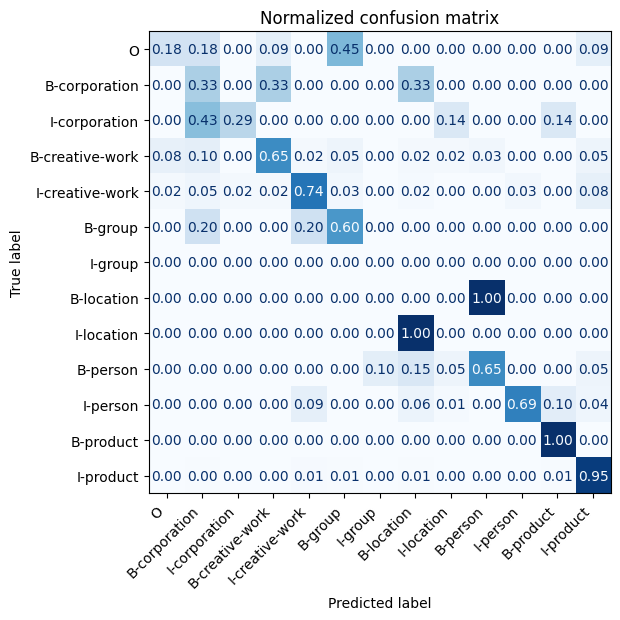

In [48]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], label_names)